<a href="https://colab.research.google.com/github/ginchu/breast-cancer-image-segmentation/blob/main/train_fpn_withAug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook trains an [FPN](http://presentations.cocodataset.org/COCO17-Stuff-FAIR.pdf) model, a type of fully convolutional neural network, on the augmented version of the TNBC_NucleiSegmentation dataset. The FPN model implementation used here is provided in the popular [segmentation-models-pytorch library](https://github.com/qubvel/segmentation_models.pytorch).

## Setup

In [1]:
! pip install segmentation-models-pytorch
! pip install wandb

     |████████████████████████████████| 88 kB 2.8 MB/s 
     |████████████████████████████████| 376 kB 37.5 MB/s 
     |████████████████████████████████| 58 kB 6.2 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=9986c61887387f263e7bfc938b888ca7c157935d294cbe4e64ec788e44621502
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=623a729fe688eb34d3f266777d13ec3711c5d64e618238605e6bc268cc5846d4
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 181 kB 62.1 MB/s 
     |████████████████████████████████| 145 kB 69.9 MB/s 
     |████████████████████████████████

In [2]:
# load repo and data
print('Loading data...')
! git clone https://github.com/ginchu/breast-cancer-image-segmentation.git
print('Done!')

% cd breast-cancer-image-segmentation/

Loading data...
Cloning into 'breast-cancer-image-segmentation'...
remote: Enumerating objects: 587, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 587 (delta 8), reused 23 (delta 8), pack-reused 564
Receiving objects: 100% (587/587), 322.38 MiB | 40.61 MiB/s, done.
Resolving deltas: 100% (39/39), done.
Checking out files: 100% (557/557), done.
Done!
/content/breast-cancer-image-segmentation


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

import segmentation_models_pytorch as smp
import data
import aug_data

import wandb

In [4]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
num_epochs = 150
test_split = 0.3
batch_size = 8
#SEED = 42
lr = 0.003

## **D**ata

In [6]:
data = aug_data.AugDataset()
print(len(data))
print(data[1][0].shape)

220
torch.Size([3, 512, 512])


Generate train and test indices, then create data loaders for train and test sets

In [7]:
train_indices, test_indices, _, _ = train_test_split(
    range(len(data)),
    data.y,
    test_size=test_split
)

train = Subset(data, train_indices)
test = Subset(data, test_indices)

train_generator = DataLoader(train, batch_size=batch_size, shuffle=True)
test_generator = DataLoader(test, batch_size=batch_size, shuffle=True)

train_size, test_size = len(train), len(test)
print(train_size, test_size)

154 66


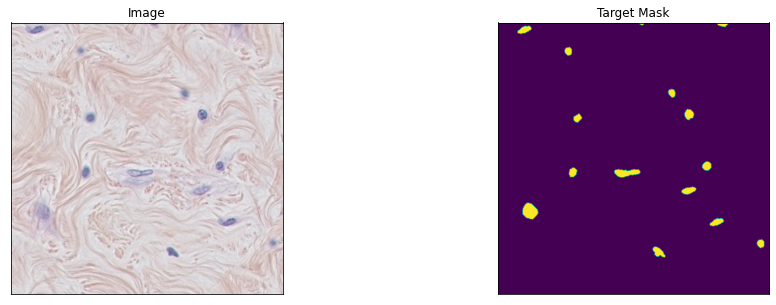

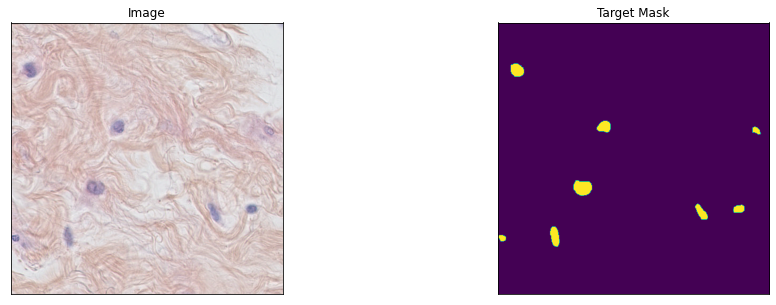

In [8]:
# helper function for data visualization
# from https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

img, mask = data[3]
visualize(
    image=img.permute(2,1,0),
    target_mask=mask.squeeze().permute(1,0)
)

img, mask = data[20]
visualize(
    image=img.permute(2,1,0),
    target_mask=mask.squeeze().permute(1,0)
)

## **M**odel

In [10]:
ENCODER = 'resnet34' # default for FPN
ENCODER_WEIGHTS = 'imagenet' # default for FPN

model = smp.FPN(encoder_name = ENCODER,
                encoder_weights = ENCODER_WEIGHTS,
                in_channels = 3,
                classes = 1,
                activation = 'sigmoid')

## **L**oss

In [11]:
loss = smp.utils.losses.DiceLoss()

metrics = [
           smp.utils.metrics.IoU(threshold=0.5)
]

## **O**ptimizer

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## Training loop

In [13]:
config_dict = dict(
    data = 'aug',
    epochs = num_epochs,
    batch_size = batch_size,
    dataset_len = len(data),
    test_split = test_split,
    lr = lr
)

wandb.init(project = 'BIA final', entity = 'weiss', config = config_dict)

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss = loss,
    metrics = metrics,
    optimizer = optimizer,
    device = 'cuda',
    verbose = True
)

tr_loss = []

max_score = 0

for epoch in range(num_epochs):
  
  print('\nEpoch: {}'. format(epoch))

  train_logs = train_epoch.run(train_generator)

  if max_score < train_logs['iou_score']:
    max_score = train_logs['iou_score']
    torch.save(model, './best_FPN_aug.pth')
    print('Model saved!')

  tr_loss.append(train_logs)

  wandb.log({'Epoch Dice Loss': train_logs['dice_loss'],
             'Epoch IoU Score': train_logs['iou_score'],
             'Best IoU Score': max_score})
  

wandb: Currently logged in as: weiss. Use `wandb login --relogin` to force relogin



Epoch: 0
train: 100%|██████████| 20/20 [00:12<00:00,  1.62it/s, dice_loss - 0.7468, iou_score - 0.1465]
Model saved!

Epoch: 1
train: 100%|██████████| 20/20 [00:11<00:00,  1.77it/s, dice_loss - 0.747, iou_score - 0.1455]

Epoch: 2
train: 100%|██████████| 20/20 [00:11<00:00,  1.78it/s, dice_loss - 0.7522, iou_score - 0.1423]

Epoch: 3
train: 100%|██████████| 20/20 [00:11<00:00,  1.77it/s, dice_loss - 0.7454, iou_score - 0.1471]
Model saved!

Epoch: 4
train: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s, dice_loss - 0.7453, iou_score - 0.1477]
Model saved!

Epoch: 5
train: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s, dice_loss - 0.711, iou_score - 0.1723]
Model saved!

Epoch: 6
train: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s, dice_loss - 0.3839, iou_score - 0.4538]
Model saved!

Epoch: 7
train: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s, dice_loss - 0.3151, iou_score - 0.5258]
Model saved!

Epoch: 8
train: 100%|██████████| 20/20 [00:11<00:00,  1.73it/s, dice_loss - 0.3105,

## Visualization of test set predictions
#### Overall test set performance

In [14]:
# adapted from https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

best_model = torch.load('./best_FPN_aug.pth')

test_epoch = smp.utils.train.ValidEpoch(
    model = best_model,
    loss = loss,
    metrics = metrics,
    device = 'cuda',
    verbose = True
)

logs = test_epoch.run(test_generator)

valid: 100%|██████████| 9/9 [00:03<00:00,  2.73it/s, dice_loss - 0.2275, iou_score - 0.6315]


#### Images with best and worst performance

In [15]:
! pip install torchmetrics

from torchmetrics import JaccardIndex # same as IoU used above

jaccard = JaccardIndex(num_classes = 2,
                       threshold = 0.5)

test_ious = []

for i in range(len(test)):
  img, gt_mask = test[i]
  gt_mask = gt_mask.squeeze().int()

  x_tensor = img.to('cuda').unsqueeze(0)

  pred = best_model.predict(x_tensor)
  pred = pred.squeeze().cpu().round()
  
  test_ious.append(jaccard(pred.unsqueeze(0), gt_mask.unsqueeze(0)))

best_3 = np.argsort(test_ious)[-3:]
worst_3 = np.argsort(test_ious)[:3]



     |████████████████████████████████| 409 kB 5.1 MB/s 


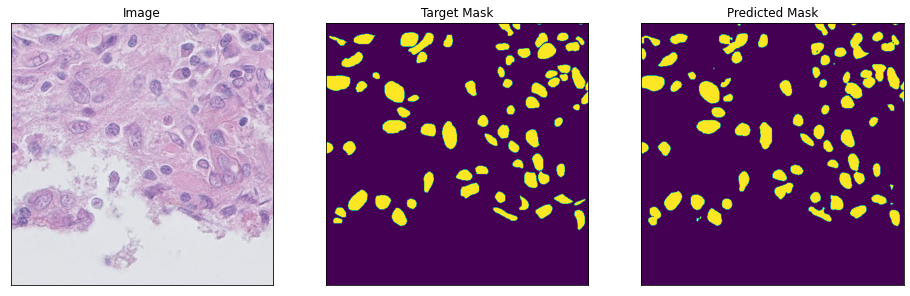

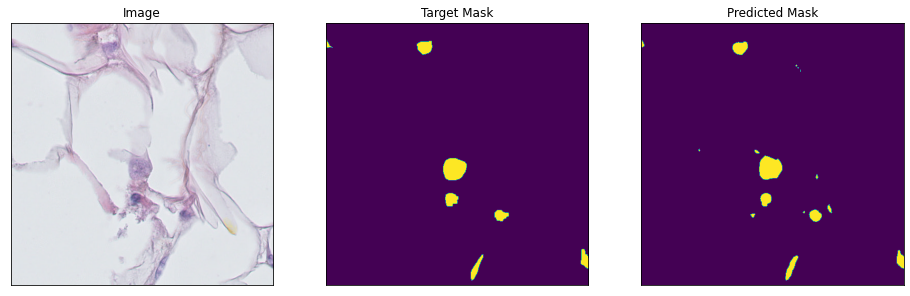

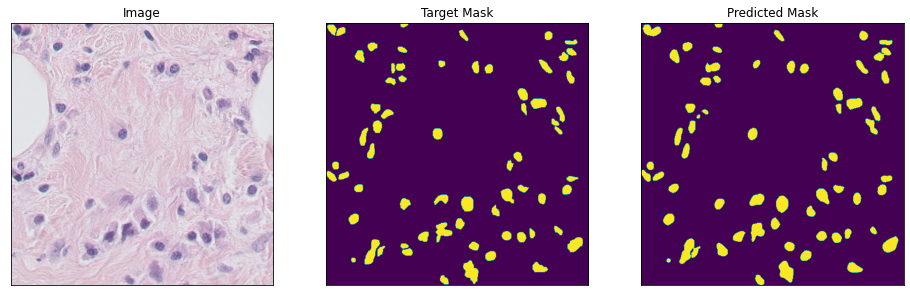

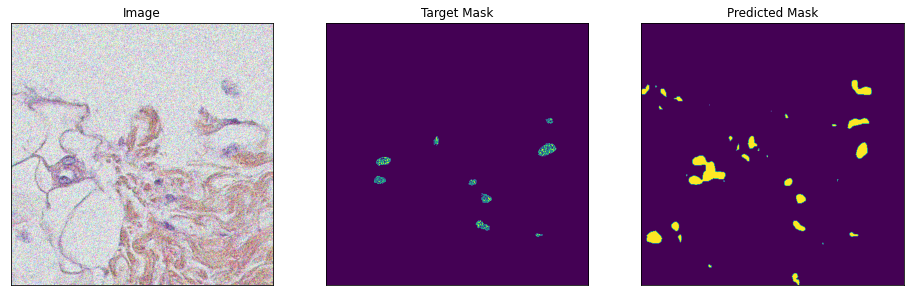

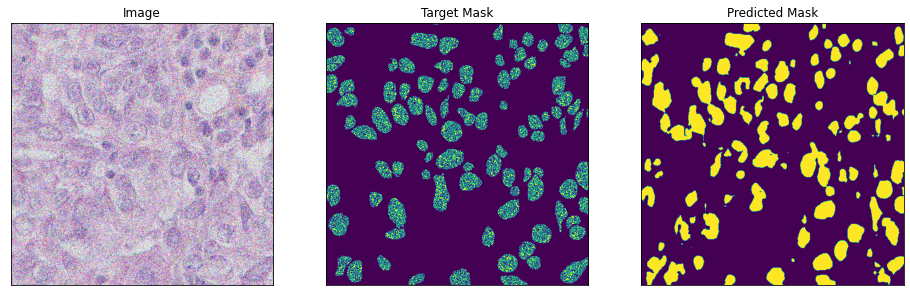

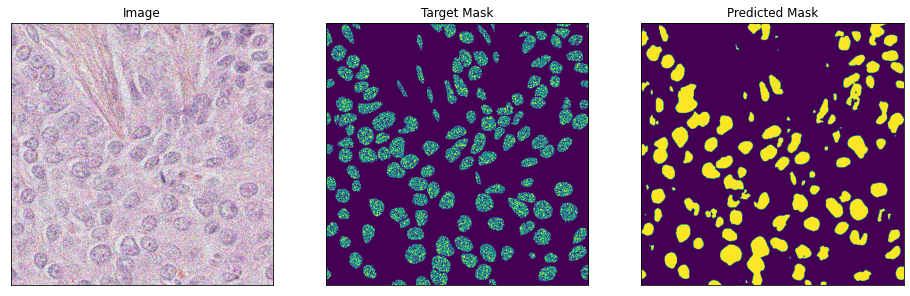

In [16]:
to_plot = list(np.hstack((best_3, worst_3)))

for i in to_plot:
  img, gt_mask = test[i]

  gt_mask = gt_mask.squeeze().int()

  x_tensor = img.to('cuda').unsqueeze(0)

  pred = best_model.predict(x_tensor)
  pred = (pred.squeeze().cpu().round())

  visualize(
      image = img.permute(1,2,0),
      target_mask = gt_mask,
      predicted_mask = pred
  )